In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
img_size = (150, 150)
batch_size = 32
seed = 42

In [3]:
data_dir = "GroceryStoreDataset/dataset"

In [4]:
df_classes = pd.read_csv(data_dir + "/classes.csv")
df_classes.sample(5)

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
45,Oatly-Oat-Milk,45,Oat-Milk,22,/iconic-images-and-descriptions/Packages/Oat-M...,/iconic-images-and-descriptions/Packages/Oat-M...
34,Tropicana-Apple-Juice,34,Juice,19,/iconic-images-and-descriptions/Packages/Juice...,/iconic-images-and-descriptions/Packages/Juice...
29,Bravo-Orange-Juice,29,Juice,19,/iconic-images-and-descriptions/Packages/Juice...,/iconic-images-and-descriptions/Packages/Juice...
76,Red-Beet,76,Red-Beet,40,/iconic-images-and-descriptions/Vegetables/Red...,/iconic-images-and-descriptions/Vegetables/Red...
16,Orange,16,Orange,9,/iconic-images-and-descriptions/Fruit/Orange/O...,/iconic-images-and-descriptions/Fruit/Orange/O...


In [5]:
coarse_mapping = dict(df_classes[["Coarse Class ID (int)", "Coarse Class Name (str)"]].drop_duplicates().values)
filter_img = [0,1,2]
coarse_mapping = {k: v for k, v in coarse_mapping.items() if k in filter_img}
coarse_mapping

{0: 'Apple', 1: 'Avocado', 2: 'Banana'}

In [6]:
df_train = pd.read_csv(data_dir + "/train.txt",names= ['path','fine','coarse'])
df_val = pd.read_csv(data_dir + "/val.txt",names= ['path','fine','coarse'])
df_test = pd.read_csv(data_dir + "/test.txt",names= ['path','fine','coarse'])

In [7]:
df_train = df_train[df_train.coarse.isin(filter_img)]
df_val = df_val[df_val.coarse.isin(filter_img)]
df_test = df_test[df_test.coarse.isin(filter_img)]

In [8]:
df_train.sample(5)

,path,fine,coarse
138,train/Fruit/Apple/Pink-Lady/Pink-Lady_035.jpg,2,0
322,train/Fruit/Banana/Banana_004.jpg,6,2
293,train/Fruit/Avocado/Avocado_016.jpg,5,1
171,train/Fruit/Apple/Red-Delicious/Red-Delicious_...,3,0
80,train/Fruit/Apple/Granny-Smith/Granny-Smith_03...,1,0


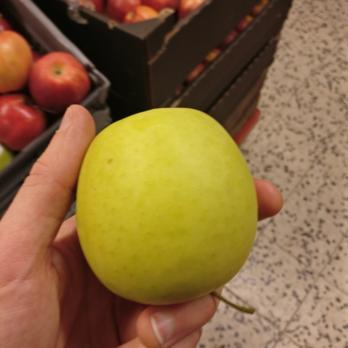

In [9]:
image = PIL.Image.open(data_dir + '/' + df_train.path.values[0])
image

In [10]:
df_train["coarse_name"] = df_train["coarse"].map(coarse_mapping)
counts = df_train["coarse_name"].value_counts()
counts

coarse_name
Apple      278
Banana      45
Avocado     41
Name: count, dtype: int64

In [11]:
def load_images_from_folder(data_dir, paths):
    image_ds = []
    for path in paths:
        s = data_dir + '/' + path
        img = PIL.Image.open(s)
        img = img.resize(img_size)
        image_ds.append(img)
    image_array = np.asarray(image_ds)
    return image_array

In [12]:
with ThreadPoolExecutor() as executor:
  t1 = executor.submit(load_images_from_folder, data_dir, df_train['path'].values,)
  t2 = executor.submit(load_images_from_folder, data_dir, df_val['path'].values,)
  t3 = executor.submit(load_images_from_folder, data_dir, df_test['path'].values,)
  X_train = t1.result()
  X_val = t2.result()
  X_test = t3.result()

In [13]:
X_train.shape

(364, 150, 150, 3)

In [14]:
y_train = df_train['coarse'].values
y_val = df_val['coarse'].values
y_test = df_test['coarse'].values

In [15]:
y_train.shape

(364,)

In [ ]:
def augment_images(X, y, label, num):
    X_generated, y_generated = [], []
    idx = np.where(y == label)[0]
    data_augmentation = Sequential([
      RandomFlip("horizontal_and_vertical"),
      RandomRotation(0.2),
      RandomZoom(0.1),
    ])
    for _ in range(num - len(idx)):
      idx_ = np.random.choice(idx)
      img  X_train[idx_]
      img = data_augmentation(img)
      X_generated.append(img)
      y_generated.append(label)
    return np.asarray(X_generated), np.asarray(y_generated)

In [17]:
labels = np.unique(y_train)
X_train_augmented, y_train_augmented = np.copy(X_train), np.copy(y_train)
for label in labels:
  X_, y_ = augment_images(X_train, y_train, label, 1000,)
  X_train_augmented = np.concatenate([X_train_augmented, X_], axis=0)
  y_train_augmented = np.concatenate([y_train_augmented, y_], axis=0)

In [18]:
X_train_augmented.shape

(3000, 150, 150, 3)

In [19]:
y_train_augmented.shape

(3000,)

In [20]:
def format_img(image, label):
  image = tf.cast(image, tf.float16)
  image = preprocess_input(image)
  return image, label

def create_dataset(x, y, is_training=False, batch_size=batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(format_img, num_parallel_calls=tf.data.AUTOTUNE)
  if is_training:
    dataset = dataset.shuffle(1000)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [21]:
train_ds = create_dataset(X_train_augmented, y_train_augmented, is_training=True)
val_ds = create_dataset(X_val, y_val)
test_ds = create_dataset(X_test, y_test)

In [22]:
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_size + (3,),
)
base_model.trainable = False

In [23]:
model = Sequential([
    Input(shape=img_size + (3,)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(3, activation="softmax"),
])

In [24]:
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [25]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/30
94/94 - 10s - loss: 3.9048 - accuracy: 0.8537 - val_loss: 0.0062 - val_accuracy: 1.0000 - 10s/epoch - 110ms/step
Epoch 2/30
94/94 - 8s - loss: 0.1257 - accuracy: 0.9787 - val_loss: 3.5508e-04 - val_accuracy: 1.0000 - 8s/epoch - 88ms/step
Epoch 3/30
94/94 - 8s - loss: 0.1037 - accuracy: 0.9877 - val_loss: 1.2874e-04 - val_accuracy: 1.0000 - 8s/epoch - 88ms/step
Epoch 4/30
94/94 - 8s - loss: 0.0479 - accuracy: 0.9947 - val_loss: 3.6124e-09 - val_accuracy: 1.0000 - 8s/epoch - 88ms/step
Epoch 5/30
94/94 - 8s - loss: 0.0057 - accuracy: 0.9990 - val_loss: 3.6124e-09 - val_accuracy: 1.0000 - 8s/epoch - 87ms/step
Epoch 6/30
94/94 - 8s - loss: 0.0022 - accuracy: 0.9987 - val_loss: 8.2619e-05 - val_accuracy: 1.0000 - 8s/epoch - 87ms/step
Epoch 7/30
94/94 - 8s - loss: 0.0194 - accuracy: 0.9970 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 8s/epoch - 88ms/step
Epoch 8/30
94/94 - 8s - loss: 7.6304e-04 - accuracy: 0.9997 - val_loss: 3.6124e-09 - val_accuracy: 1.0000 - 8s/epoch - 87ms/st

In [26]:
y_pred = np.argmax(model.predict(test_ds), axis=1)

12/12 [==============================] - 2s 100ms/step


In [27]:
f1_score(y_test, y_pred, average='weighted')

0.9772847950870626

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       276
           1       0.94      0.85      0.89        40
           2       0.96      1.00      0.98        44

    accuracy                           0.98       360
   macro avg       0.96      0.95      0.95       360
weighted avg       0.98      0.98      0.98       360



In [29]:
confusion_matrix(y_test, y_pred)

array([[274,   2,   0],
       [  4,  34,   2],
       [  0,   0,  44]])

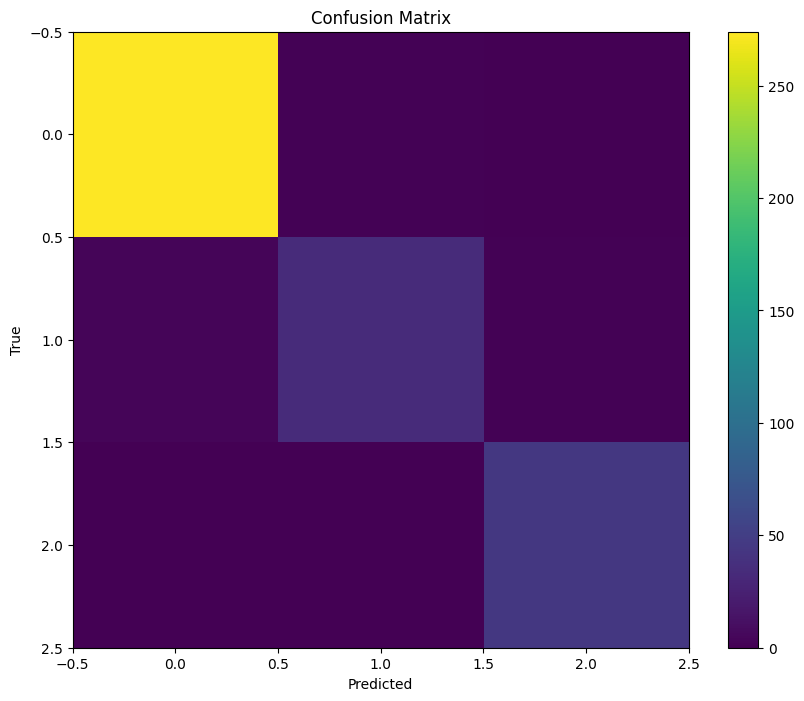

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()